# Neural Processes (https://arxiv.org/pdf/1807.01622.pdf)

Neural Processes (NPs) are a neural latent variable model that can be used to learn a distribution of functions. Given some data, NPs can learn the underlying distribution of the family of functions the data comes from. 

Gaussian Processes can also learn a distribution of a family of functions. They do this by first assuming a Gaussian prior with an appropriate choice of covariance matrix. By combining the data that comes from the family of functions with the prior distribution using Bayes' Theorem, an updated posterior distribution can be computed. This gives us a probabilistic model over the possible functions the data may follow and allows us to measure uncertainty at every point in the domain. 

Similar to GPs, a prior distribution of the data is also used in NPs. Unlike GPs, the prior distribution is learned explicitly from the data via the training of a neural network, rather than manually choosing a covariance matrix that we deem appropriate. This is extremely beneficially, as it allows us to learn complex family of distributions such as images, which are known to be difficult for GPs.

NPs also hold another benefit over GPs, computing the posterior distribution in a linear time complexity. This is a major advantage over the $O(N^3)$ time complexity, where N is the number of contextual points, that it takes GPs due to having to invert a matrix. When the number of contextual points grows large, GPs become very hard to evaluate.

#### Neural Process Model
Neural Processes can be broken down into three distinct parts. 

- Encoder: encodes pairs of data points $(x_i, y_i)$ into a representation $r_i$.
- Aggregator: aggregates the representations $r_i$ into a single entity, $\bar{r}$, which is used to parametrise the latent distribution $z \sim \mathcal{N}(\mu(\bar{r}), \sigma(\bar{r}))$.  This introduces invariance to the order of the context points
- Decoder: transforms samples from the latent distribution $z$ with target $x$ values to produce output target $y$ values.

![image.png](https://raw.githubusercontent.com/kasparmartens/NeuralProcesses/master/fig/schema3.png)
(Courtesy of https://kasparmartens.rbind.io/post/np/)

The image above shows a graphical model of the neural process, where the left hand-side denotes the encoder, the middle denotes the aggregator and the right hand-side denotes the decoder.

In order to learn, a loss function has to be constructed which captures the task at hand. In this case, the variational ELBO-loss is used.

$$\text{ELBO} = \mathbb{E}_{q(z|\text{context}, \text{target})} \bigg[\sum_{t=1}^{T} \log{p(y_t^* | z, x_t^*)} + \log{\frac{q(z|\text{context})}{q(z|\text{context}, \text{target})}}\bigg]$$

Essentially, these two terms correspond to the log-likelihood of the data (how well the model predicts the targets) and the negative KL-divergence between two probability distributions. These two probability distributions allow us to generate latent variables to be decoded -- the difference being: one has access to both context and target data in training and the other only has access to a subset of the context points. Therefore, by maximising the negative KL divergence between these two distributions, we are trying to match their generative power. The hope is that this will allow us to sample from the distribution defined by a subset of the context points, but will have similar generative power to that of sampling from a distribution where all the data points are known.



In [35]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.distributions import MultivariateNormal
from neural_processes import NeuralProcess
from loss import loglikelihood, kl_div, kl_div_gaussians

#### Sampling from the untrained decoder $P(y_t | z, x_t)$
Before training the neural network, functions can be sampled from the distribution. This is interesting, as we can see that the architecture of the neural network plays a key role in the type of functions that will be learned.

In this experiment, we will sample using three different activation functions: Sigmoid, ReLU, and Tanh. We will also vary the dimensionality of the latent variable $z$.

As can be seen below, the activation functions used have major implications on the type of functions that are sampled. In the case of Sigmoid activation, the functions sampled seem to have a narrow range as compared to the ReLU and Tanh activation functions. Sampling from the ReLU activations produce more rigid functions.

Another interesting observation to note is that as the latent dimension increases, the sampled functions become more spaced out -- covering a larger range of possible functions.

In [38]:
x_dim = 1
y_dim = 1
r_dim = 1
z_dim = 1
h_hidden = 10
g_hidden = 10
number_of_samples = 70

<IPython.core.display.Javascript object>


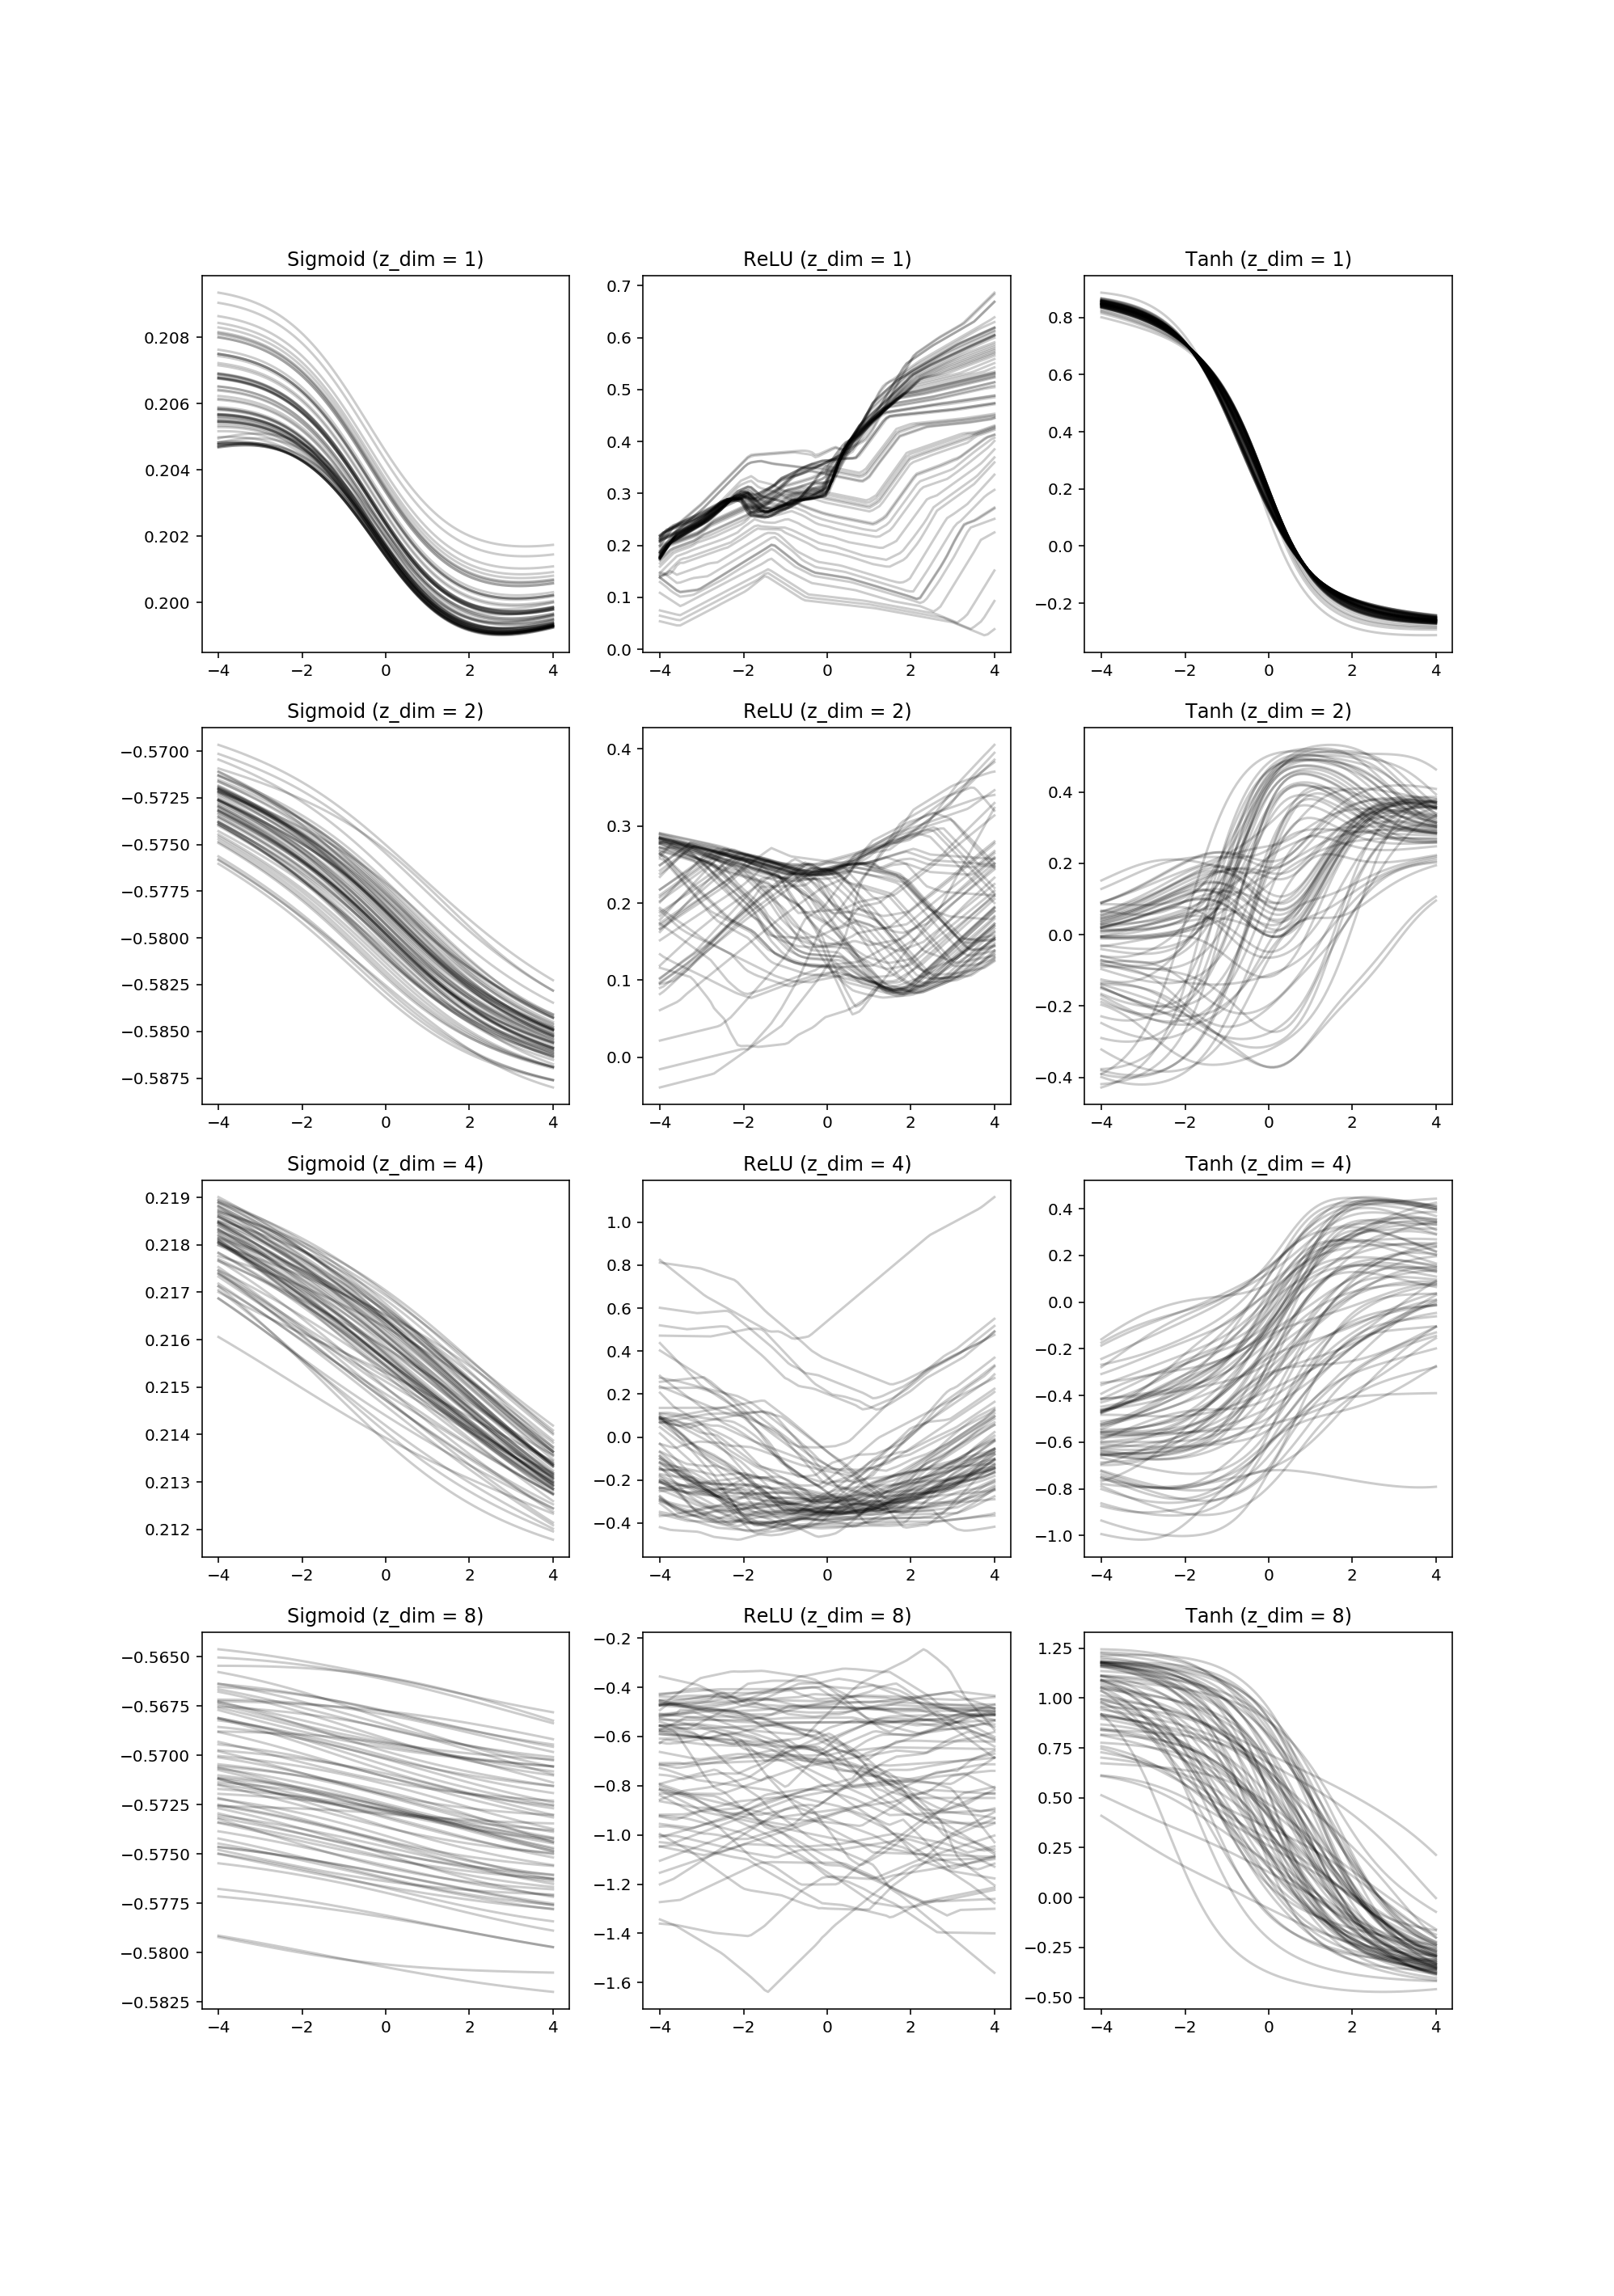

In [39]:
%matplotlib notebook

activations_dict = {
    'Sigmoid': nn.Sigmoid(),
    'ReLU': nn.ReLU(),
    'Tanh': nn.Tanh()
}

z_dims = [1, 2, 4, 8]

fig, ax = plt.subplots(4, 3)

for i, activation_key in enumerate(list(activations_dict.keys())):
    for j, z_dim in enumerate(z_dims):
        activation = activations_dict[activation_key]

        parameters = {
            'x_dim': x_dim,
            'y_dim': y_dim,
            'r_dim': r_dim,
            'z_dim': z_dim,
            'h_hidden': h_hidden,
            'g_hidden': g_hidden,
            'h_activation': activation,
            'g_activation': activation
        }

        neural_process = NeuralProcess(parameters)

        x_grid = torch.Tensor(np.linspace(-4, 4, 100)).view(1, -1 ,1)

        y_grid_samples, _, _, _ = neural_process.sample(x_grid, number_of_samples=number_of_samples)
        
        for sample in range(number_of_samples):
            x_star = x_grid.data.numpy().reshape(-1, 1)
            y_st = y_grid_samples[sample].data.numpy().reshape(-1, 1)
            ax[j][i].plot(x_star, y_st, color='black', alpha=0.2)
            ax[j][i].set_title(activation_key + " (z_dim = %d)" % z_dim)


plt.show()

# Learning a single function

Although Neural Processes can be used to learn a family of functions, they can also be used to learn a single function. In this case, neural processes will be used to model the function $\sin(x)$.

In [40]:
def function(x):
    return np.sin(x)

def split_context_target(x, y, number_of_context_points):
    mask = np.ones_like(x, dtype=bool)
    indices = np.random.choice(range(len(x)), size=number_of_context_points, replace=False)
    mask[indices] = False

    x_context = torch.Tensor(x[~mask]).view(-1, 1)
    y_context = torch.Tensor(y[~mask]).view(-1, 1)
    
    x_target = torch.Tensor(x[mask]).view(-1, 1)
    y_target = torch.Tensor(y[mask]).view(-1, 1)
    
    return x_context, y_context, x_target, y_target

number_of_points = 5
x_min = -2
x_max = 2

x = np.linspace(x_min, x_max, number_of_points)
y = function(x)

In [45]:
epochs = 300

parameters = {
        'x_dim': 1,
        'y_dim': 1,
        'r_dim': 2,
        'z_dim': 2,
        'h_hidden': 10,
        'g_hidden': 10,
        'h_activation': nn.Tanh(),
        'g_activation': nn.Tanh()
    }

neural_process = NeuralProcess(parameters)

np_parameters = list(neural_process.encoder.parameters()) + list(neural_process.decoder.parameters())
optimiser = torch.optim.Adam(np_parameters)

cache_y = []

for epoch in range(epochs):
    number_of_context_points = np.random.choice(range(1, number_of_points))
    x_context, y_context, x_target, y_target = split_context_target(x, y, number_of_context_points)
    
    x_context = x_context.reshape(1, -1, 1)
    y_context = y_context.reshape(1, -1, 1)
    x_target = x_target.reshape(1, -1, 1)
    y_target = y_target.reshape(1, -1, 1)

    ####
    outputs = neural_process.fit(x_context, y_context, x_target, y_target, number_of_samples)
    
    y_pred_mu = outputs['y_pred_mu']
    y_pred_std = outputs['y_pred_std']
    z_mu_context = outputs['z_mu_context']
    z_std_context = outputs['z_std_context']
    z_mu_all = outputs['z_mu_all']
    z_std_all = outputs['z_std_all']

    ll = loglikelihood(y_pred_mu, y_pred_std, y_target)
    kl = kl_div_gaussians(z_mu_context, z_std_context, z_mu_all, z_std_all)
    
    optimiser.zero_grad()

    loss = -ll + kl
    loss.backward()
    optimiser.step()
    
    if epoch % 50 == 0:
        x_grid = torch.Tensor(np.linspace(-6, 6, 100)).view(1, -1 ,1)

        torch.manual_seed(0)
        y_star, _, _, _ = neural_process.sample(x_grid, number_of_samples, torch.Tensor(x).view(1, -1, 1), torch.Tensor(y).view(1, -1, 1), seed=1)

        cache_y.append(y_star)
    

<IPython.core.display.Javascript object>


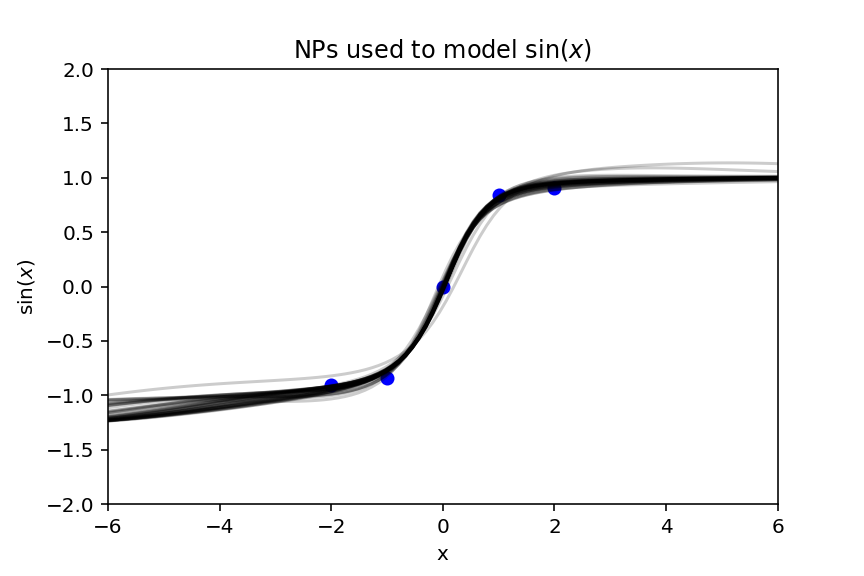

In [46]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation 
import numpy as np

fig, ax = plt.subplots()
points1, = plt.plot([], [], color='black', alpha=0.2)
ax.axis([-6, 6, -2, 2])
plt.scatter(x, y, color='b')
plt.title('NPs used to model $\sin(x)$')
plt.xlabel('x')
plt.ylabel('$\sin(x)$')

points = [plt.plot([], [], color='black', alpha=0.2) for i in range(50)]

def update(i):
    for sample in range(50):
        x_star = x_grid.data.numpy().reshape(-1, 1)
        y_st = cache_y[i][sample].data.numpy().reshape(-1, 1)
        points[sample][0].set_data(x_star, y_st)

    return points

anim = FuncAnimation(fig, update, frames=len(cache_y), repeat=False)

# Learning a family of functions

Above we saw that NPs can be used to learn a single function. Here, I will show that they can also be used to model a family of functions.

In [64]:
def set_function(a, x):
    return a * np.sin(x)**2

In [69]:
number_of_points = 50
number_of_samples = 10
x_min = -np.pi
x_max = np.pi

parameters = {
        'x_dim': 1,
        'y_dim': 1,
        'r_dim': 1,
        'z_dim': 1,
        'h_hidden': 128,
        'g_hidden': 128,
        'h_activation': nn.Tanh(),
        'g_activation': nn.Tanh()
    }

neural_process = NeuralProcess(parameters)

np_parameters = list(neural_process.encoder.parameters()) + list(neural_process.decoder.parameters())
optimiser = torch.optim.Adam(np_parameters, lr=0.001)

epochs = 16001
cache_y = []

for epoch in range(epochs):
    x = np.random.uniform(x_min, x_max, number_of_points)
    a = np.random.uniform(-3, 3)
    
    y = set_function(a, x)
    number_of_context_points = np.random.choice(range(1, number_of_points))
    x_context, y_context, x_target, y_target = split_context_target(x, y, number_of_context_points)

    x_context = x_context.reshape(1, -1, 1)
    y_context = y_context.reshape(1, -1, 1)
    x_target = x_target.reshape(1, -1, 1)
    y_target = y_target.reshape(1, -1, 1)
    
    outputs = neural_process.fit(x_context, y_context, x_target, y_target, number_of_samples)
    
    y_pred_mu = outputs['y_pred_mu']
    y_pred_std = outputs['y_pred_std']
    z_mu_context = outputs['z_mu_context']
    z_std_context = outputs['z_std_context']
    z_mu_all = outputs['z_mu_all']
    z_std_all = outputs['z_std_all']

    ll = loglikelihood(y_pred_mu, y_pred_std, y_target)
    kl = kl_div(z_mu_context, z_std_context, z_mu_all, z_std_all)
    
    optimiser.zero_grad()

    loss = -ll + kl
    loss.backward()
    optimiser.step()
    
    if epoch % 2000 == 0:
        print("Epoch %d -> Loss: %.4f" % (epoch, loss.data.numpy()))
        x_grid = torch.Tensor(np.linspace(-6, 6, 100)).view(1, -1 ,1)

        torch.manual_seed(0)
        y_star = neural_process.sample(x_grid, 50, torch.Tensor(x).view(1, -1, 1), torch.Tensor(y).view(1, -1, 1), seed=1)

        cache_y.append(y_star)

Epoch 0 -> Loss: 3.5554
Epoch 2000 -> Loss: 13.3596
Epoch 4000 -> Loss: 10.5339
Epoch 6000 -> Loss: 38.4895
Epoch 8000 -> Loss: -7.0182
Epoch 10000 -> Loss: -3.7546
Epoch 12000 -> Loss: -38.5265
Epoch 14000 -> Loss: -31.2472
Epoch 16000 -> Loss: -0.4303


### Using this trained neural process model, context points will now be introduced to show how the distribution of functions predicted changes

We will see that with increased context points, the neural process will more accurately be able to predict the target function. We can also see that it is able to predict different functions within the $f(x) = a \sin^2(x)$ family.

In [70]:
def predict_plot(a, label):
    number_of_samples = 100

    x_grid = torch.Tensor(np.linspace(-4, 4, 100)).view(1, -1 ,1)

    context_points = [[0], [0, 1], [-3, -2, -1, 0, 1, 2, 3]]
    titles = ['One context point (2 std.)', 'Two context points (2 std.)', 'Seven context points (2 std.)']

    for i, context_point in enumerate(context_points):
        fig, ax = plt.subplots()
        x_context = torch.Tensor(context_point).view(1, -1, 1)
        y_context = torch.Tensor(set_function(a, x_context))

        y_mu, y_std, z_mu, z_std = neural_process.sample(x_grid, number_of_samples, x_context, y_context)

        x_points = x_grid.data.numpy().reshape(-1)
        y_points = y_mu.mean(dim=0).data.numpy().reshape(-1)
        y_std_dev = y_std.mean(dim=0).data.numpy().reshape(-1)

        plt.plot(x_points, set_function(a, x_points), 'k--', label='True Function')
        plt.plot(x_points, y_points, color='red', label='Inferred Function')
        plt.fill_between(x_points, y_points - 2 * y_std_dev, y_points + 2 * y_std_dev, color='blue', alpha=0.25)

        plt.scatter(context_point, set_function(a, context_point), color='black', s=60, label='Context Points')

        plt.title(titles[i])
        plt.xlabel('x')
        plt.ylabel('$%s$' % label)
        plt.show()

## $$f(x) = sin^2(x)$$

<IPython.core.display.Javascript object>


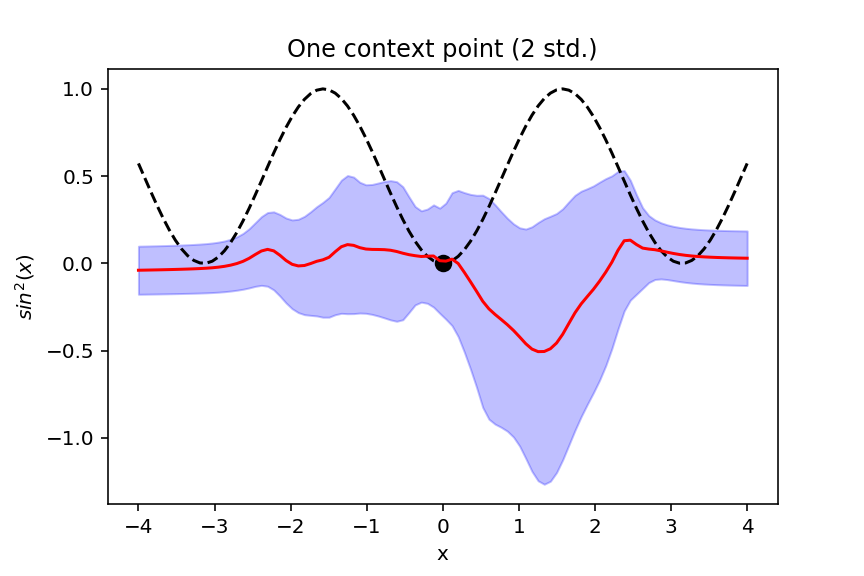

<IPython.core.display.Javascript object>


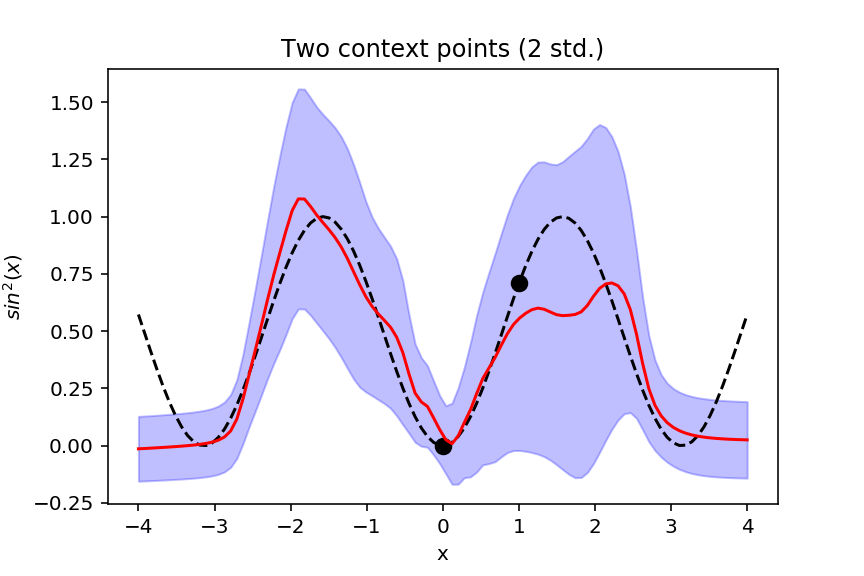

<IPython.core.display.Javascript object>


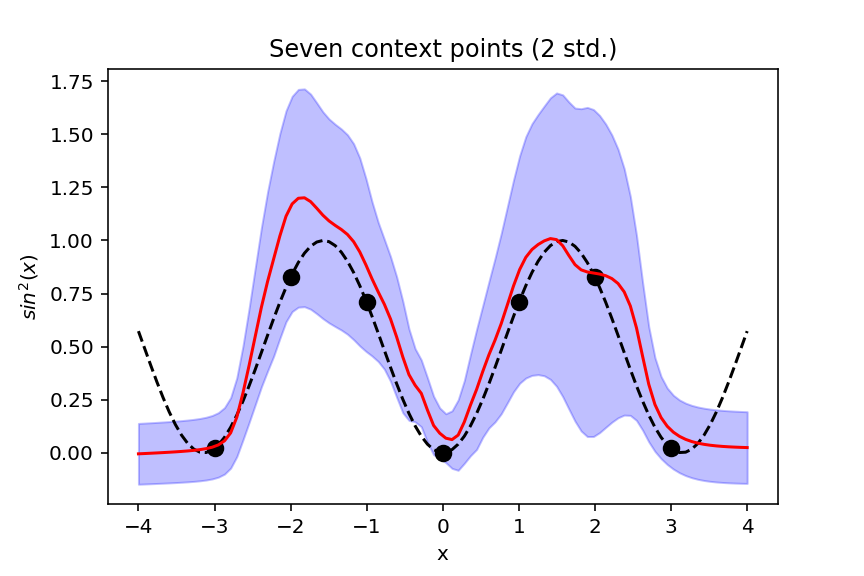

In [71]:
%matplotlib notebook

a = 1
predict_plot(a, 'sin^2(x)')

## $$f(x) = -\frac{3}{2}sin^2(x)$$

<IPython.core.display.Javascript object>


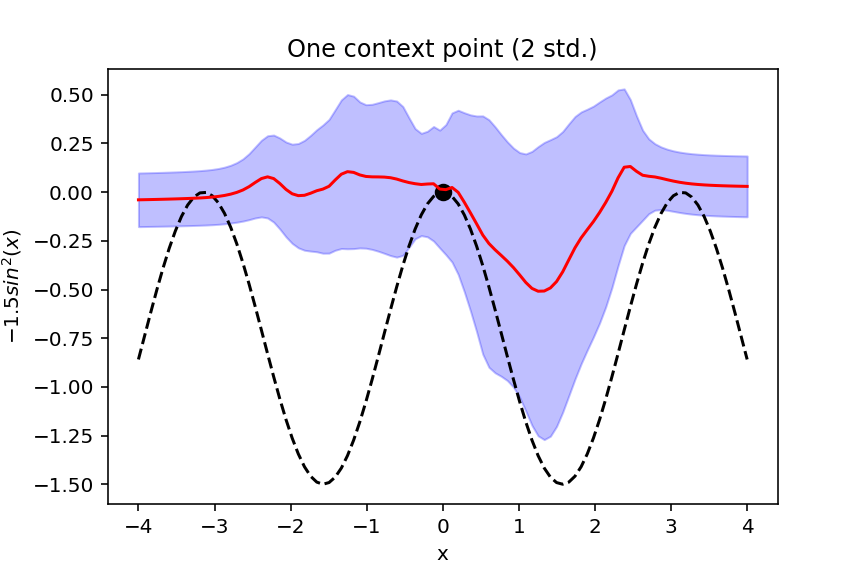

<IPython.core.display.Javascript object>


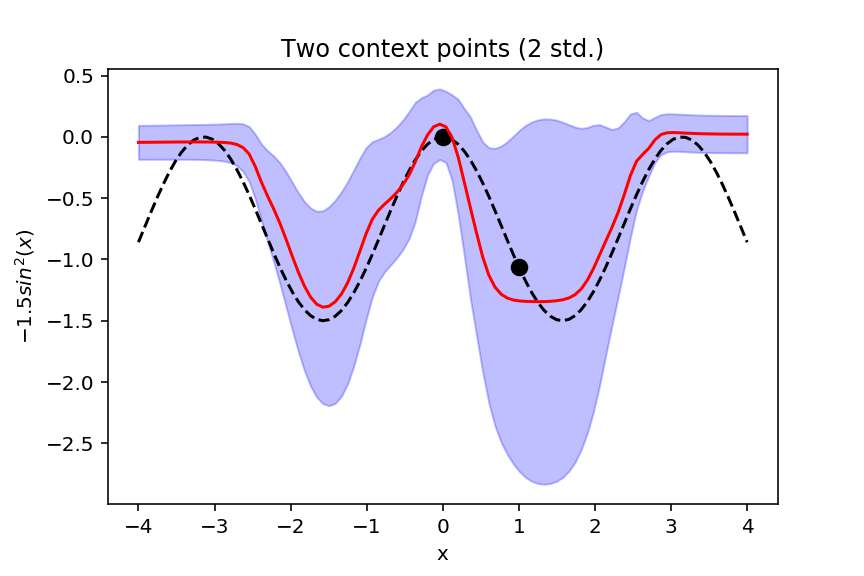

<IPython.core.display.Javascript object>


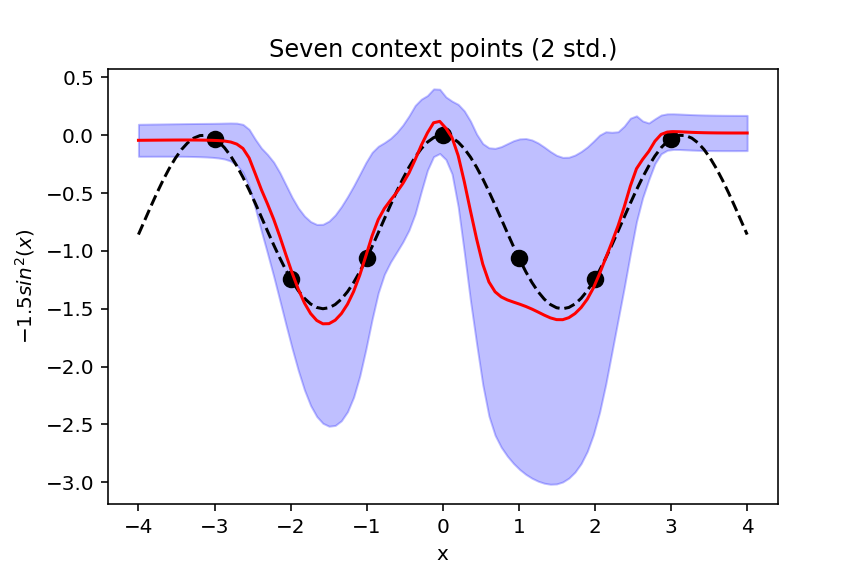

In [72]:
%matplotlib notebook

a = -1.5
predict_plot(a, '-1.5sin^2(x)')

# Neural Processes on MNIST (Regression)

In [15]:
from torchvision import datasets, transforms
from torch.nn import functional as F

batch_size = 100

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                       ])),
        batch_size=batch_size, shuffle=True)

In [16]:
def create_x_grid(width, height):
    '''
    An image pixel grid (width x height).
    '''
    
    x_grid = []

    for i in range(width):
        for j in range(height):
            x_grid.append([i, j])

    x_grid = torch.Tensor(x_grid)
    
    return x_grid

def split_context_target(x, y, number_of_context_points):  
    '''
    Creates context and target images from a set of images.
    '''
    indices = np.arange(784)
    np.random.shuffle(indices)

    context_indices = indices[:number_of_context_points]
    target_indices = indices[number_of_context_points:]
    
    x_context = x[:, context_indices]
    y_context = y[:, context_indices]
    x_target = x[:, target_indices]
    y_target = y[:, target_indices]
    
    return x_context, y_context, x_target, y_target

### Instantiate the parameters and architecture of the networks

In [6]:
parameters = {
        'x_dim': 2,
        'y_dim': 1,
        'r_dim': 128,
        'z_dim': 128,
        'h_hidden': 512,
        'g_hidden': 512,
        'h_activation': nn.ReLU(),
        'g_activation': nn.ReLU()
    }
 
    
cuda = torch.device('cuda') or False
neural_process = NeuralProcess(parameters)
number_of_samples = 1

neural_process.encoder.load_state_dict(torch.load('./encoder512_3', map_location='cpu'))
neural_process.decoder.load_state_dict(torch.load('./decoder512_3', map_location='cpu'))

np_parameters = list(neural_process.encoder.parameters()) + list(neural_process.decoder.parameters())
optimiser = torch.optim.Adam(np_parameters, lr=0.001)

### Train the network (remove break clauses)

In [7]:
epochs = 300

x_grid = create_x_grid(28, 28)

for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        
        number_of_context_points = np.random.choice(np.arange(1, 784, 1))
        x_grid_expand = x_grid.view(1, -1, 2).expand(batch_size, -1, 2)
        data = data.view(batch_size, -1, 1)
        x_context, y_context, x_target, y_target = split_context_target(x_grid_expand, data, number_of_context_points)

        outputs = neural_process.fit(x_context, y_context, x_target, y_target, number_of_samples)
    
        y_pred_mu = outputs['y_pred_mu']
        y_pred_std = outputs['y_pred_std']
        z_mu_context = outputs['z_mu_context']
        z_std_context = outputs['z_std_context']
        z_mu_all = outputs['z_mu_all']
        z_std_all = outputs['z_std_all']
        
        y_pred_mu = nn.Sigmoid()(y_pred_mu)
        
        ll = F.binary_cross_entropy(y_pred_mu, y_target, reduction="sum")
        kl = kl_div_gaussians(z_mu_context, z_std_context, z_mu_all, z_std_all)

        optimiser.zero_grad()

        loss = ll + kl
        loss.backward()
        optimiser.step()

        if batch_idx % 50 == 0:
            print("Epoch %d, Batch: %d / %d -> Loss: %.4f" % (epoch, batch_idx, 60000/batch_size, loss.cpu().data.numpy()))
        
        if loss is np.nan:
            break
            
        if batch_idx % 500 == 0 and loss != np.nan:
            torch.save(neural_process.encoder.state_dict(), './encoder256_4')
            torch.save(neural_process.decoder.state_dict(), './decoder256_4')
        break
    break
        


torch.Size([100, 784, 2])
torch.Size([100, 784, 1])
Epoch 0, Batch: 0 / 600 -> Loss: 2676.4915


### Set up and load a pre-trained model.

In [8]:
%matplotlib inline

parameters = {
        'x_dim': 2,
        'y_dim': 1,
        'r_dim': 128,
        'z_dim': 128,
        'h_hidden': 512,
        'g_hidden': 512,
        'h_activation': nn.ReLU(),
        'g_activation': nn.ReLU()
    }
 
neural_process = NeuralProcess(parameters)

neural_process.encoder.load_state_dict(torch.load('./encoder512_3', map_location='cpu'))
neural_process.decoder.load_state_dict(torch.load('./decoder512_3', map_location='cpu'))

### Generate samples, given a different amount of context points

The variance learned seems to be very small and hence the samples do not vary much from each other. This is possibly due to overfitting to the training set.

<IPython.core.display.Javascript object>


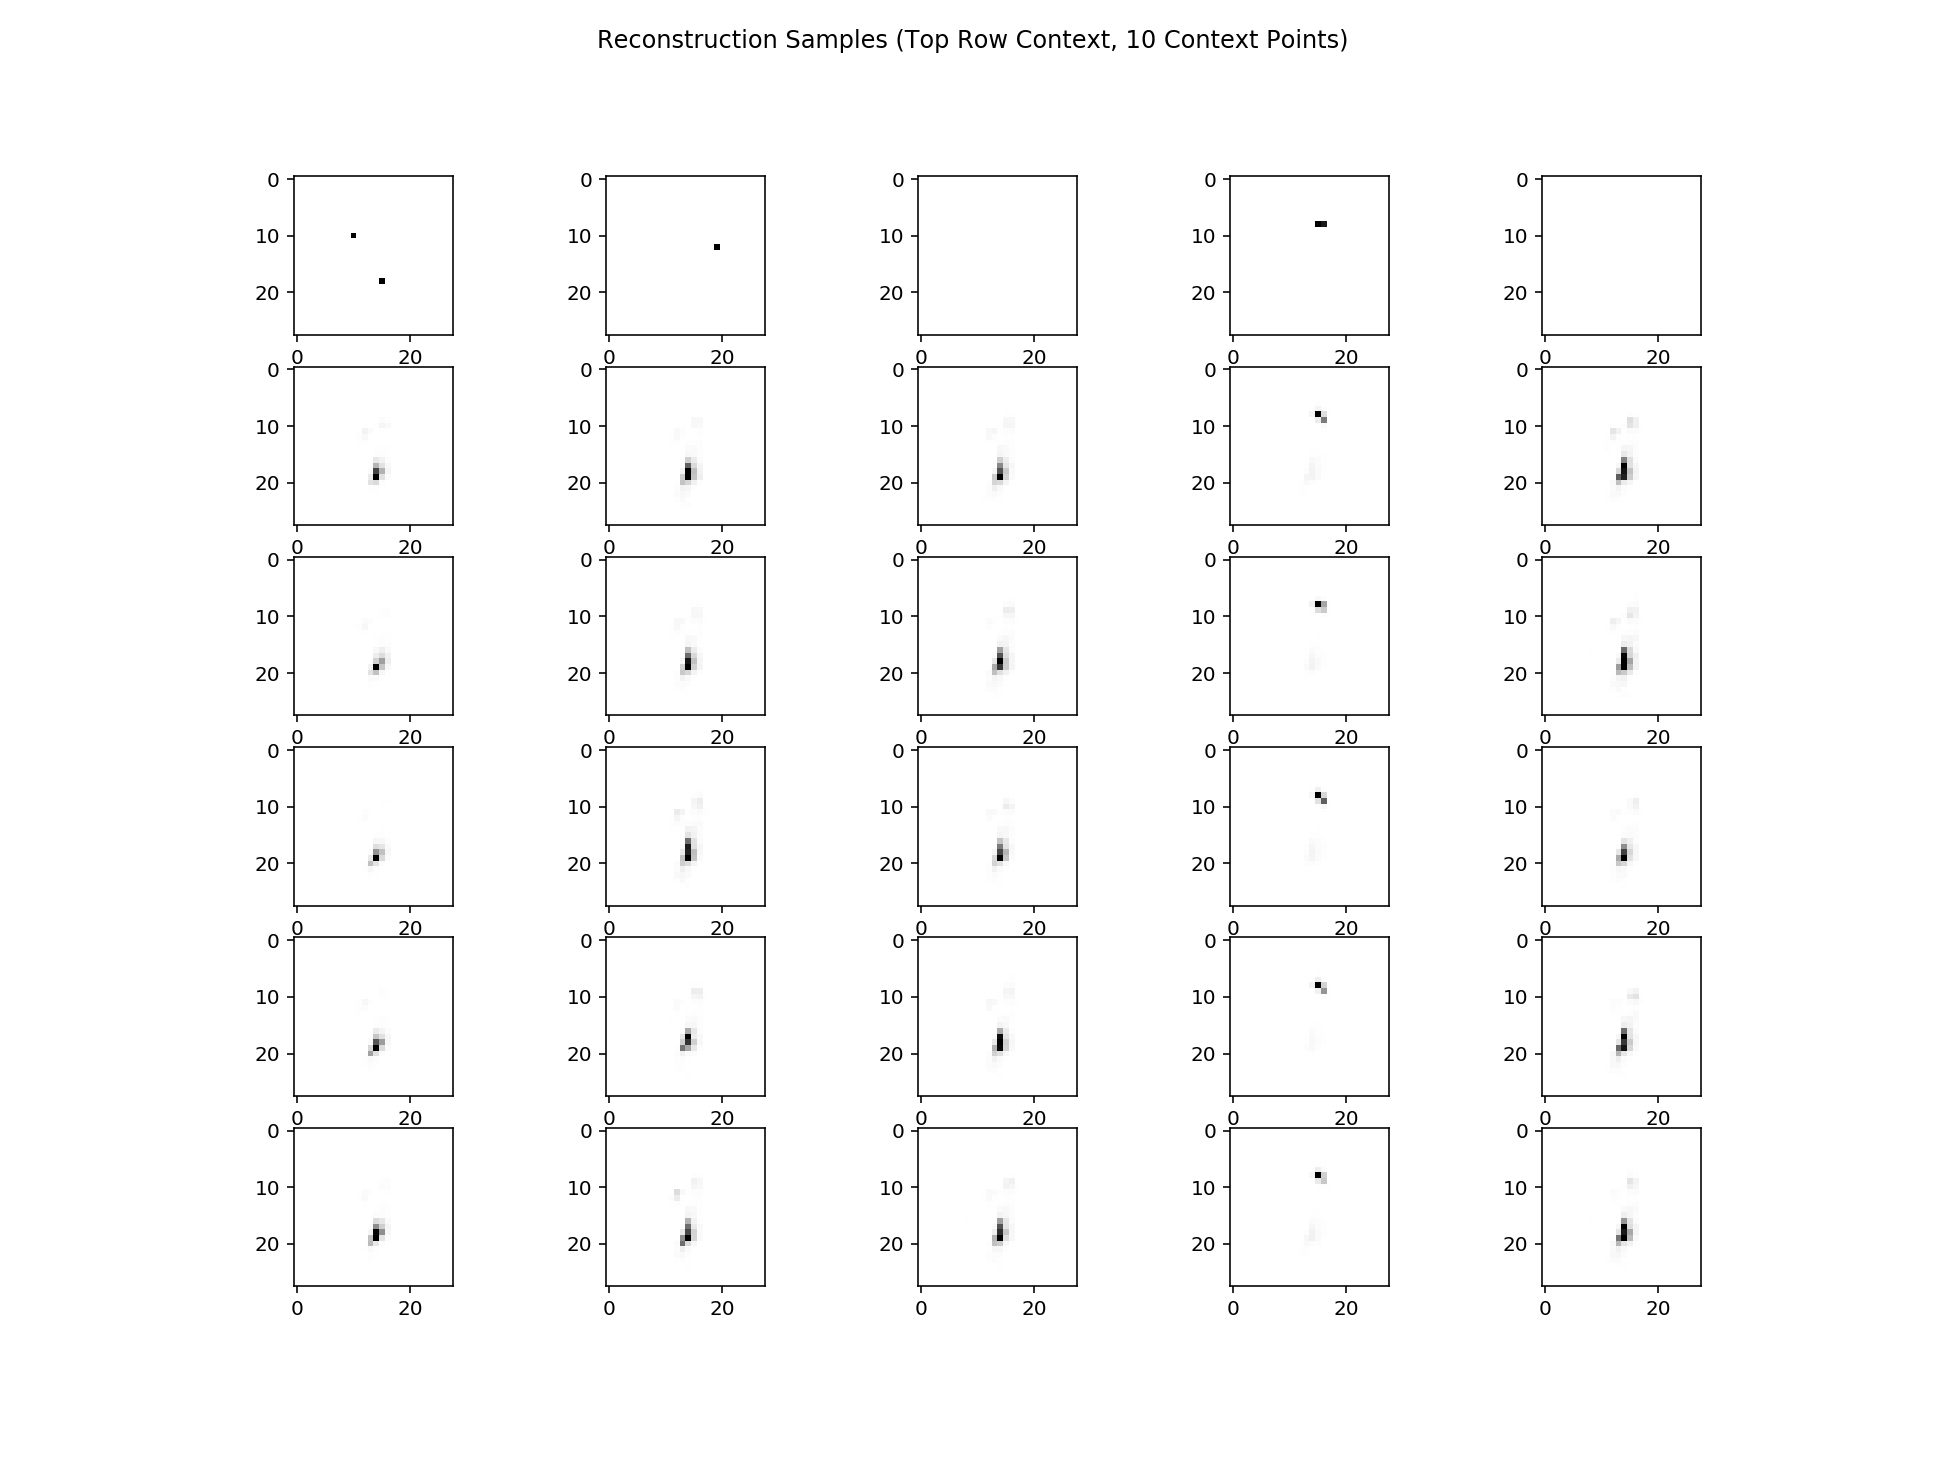

<IPython.core.display.Javascript object>


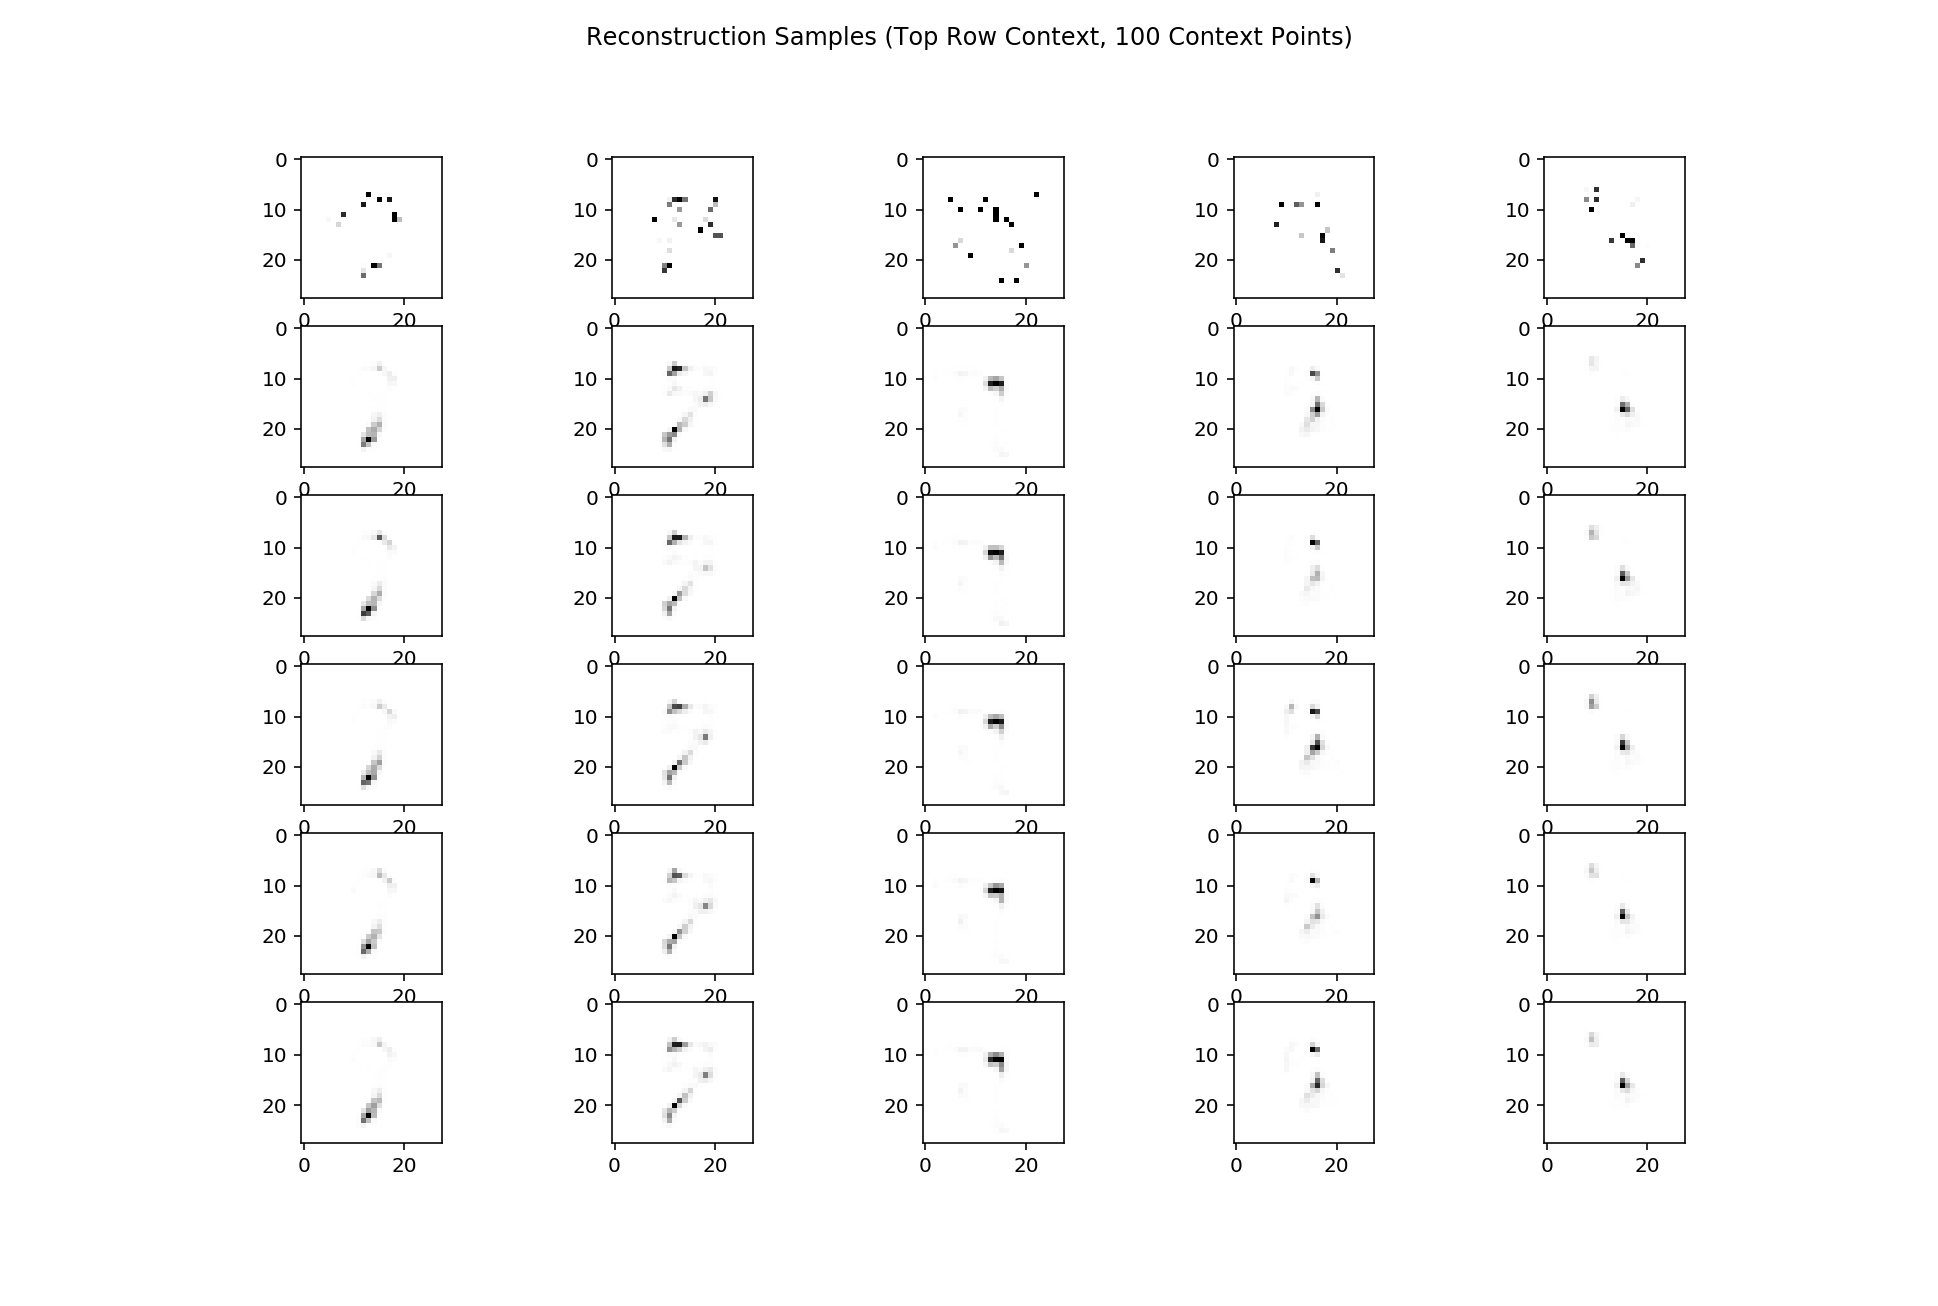

<IPython.core.display.Javascript object>


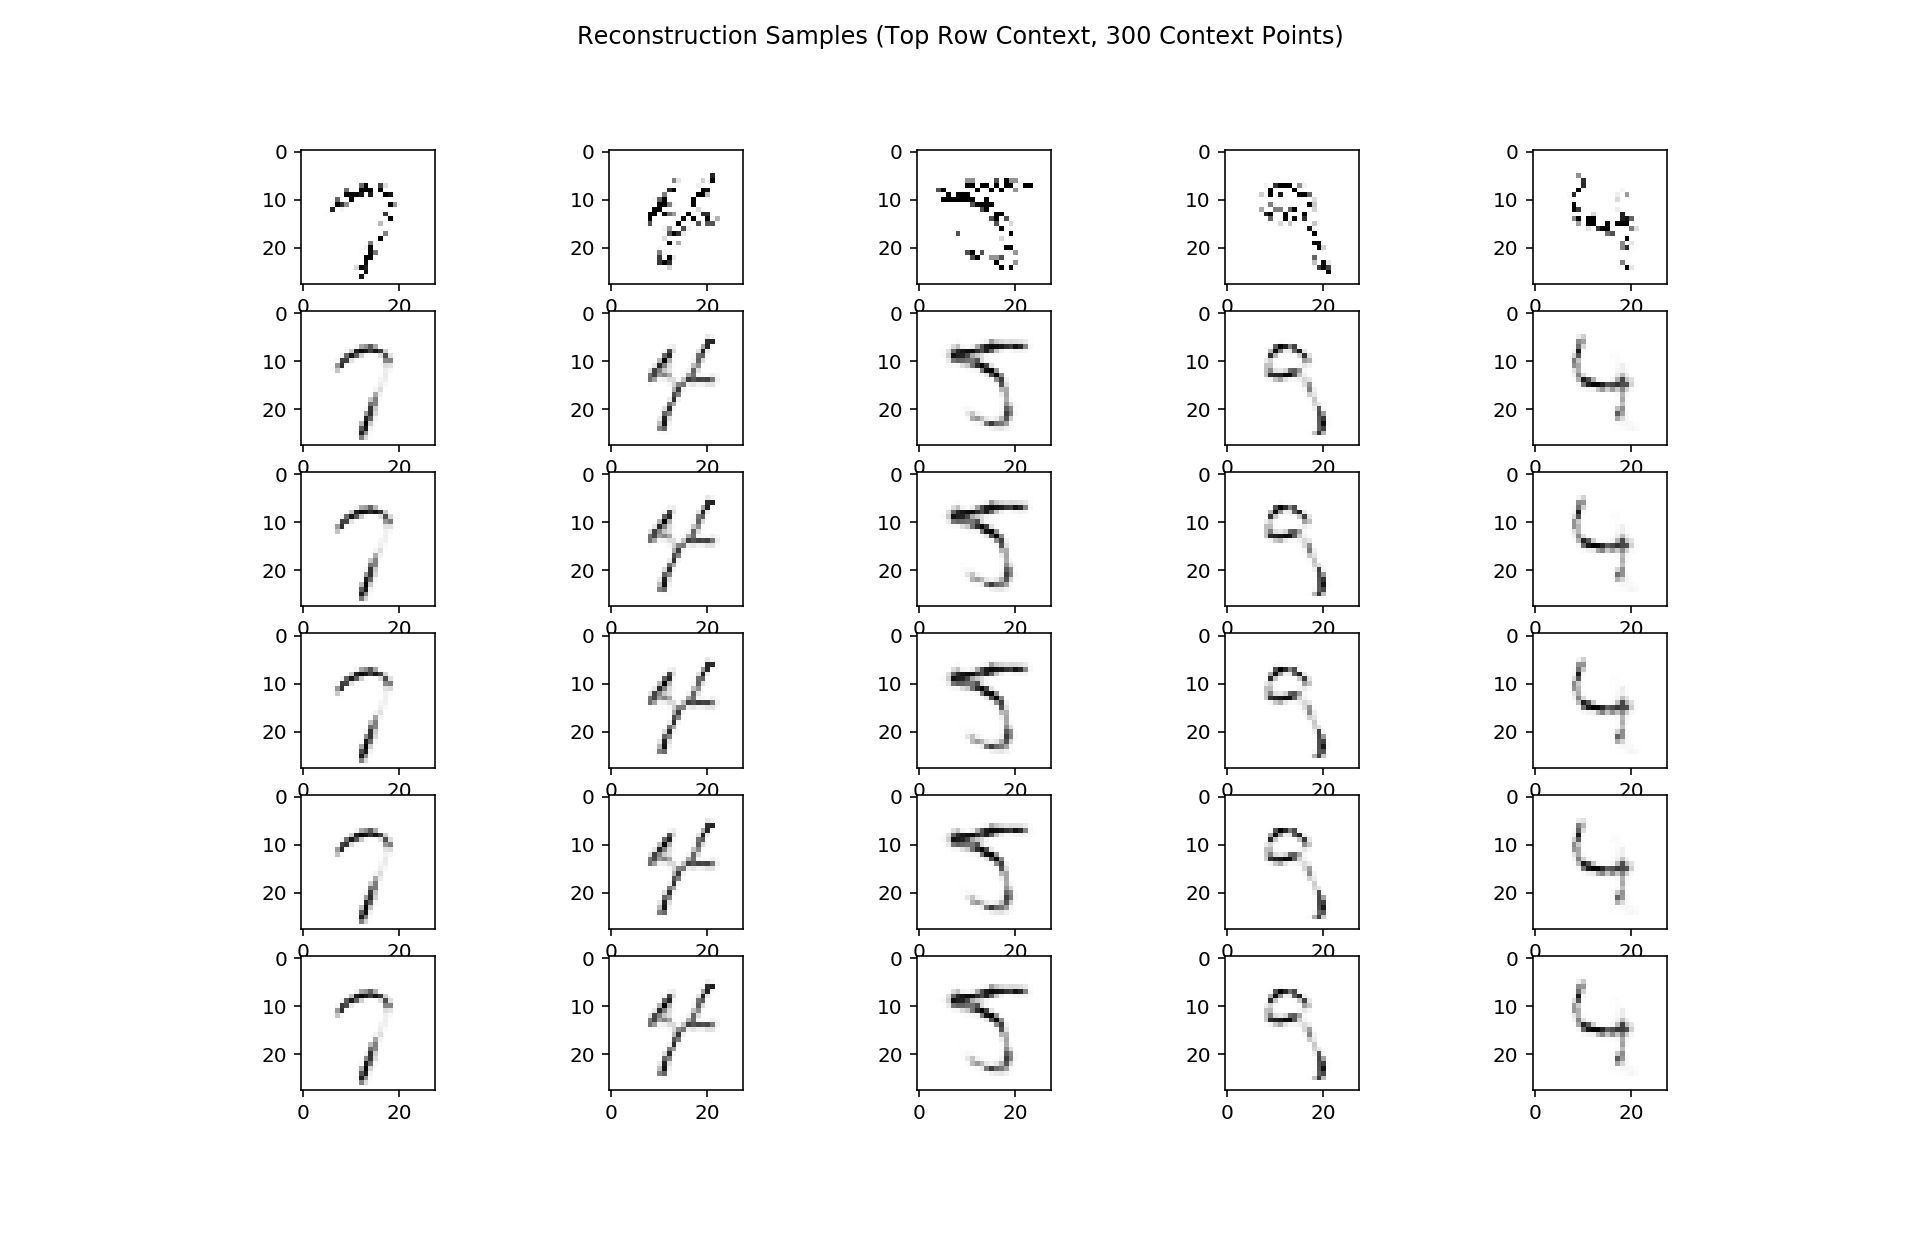

<IPython.core.display.Javascript object>


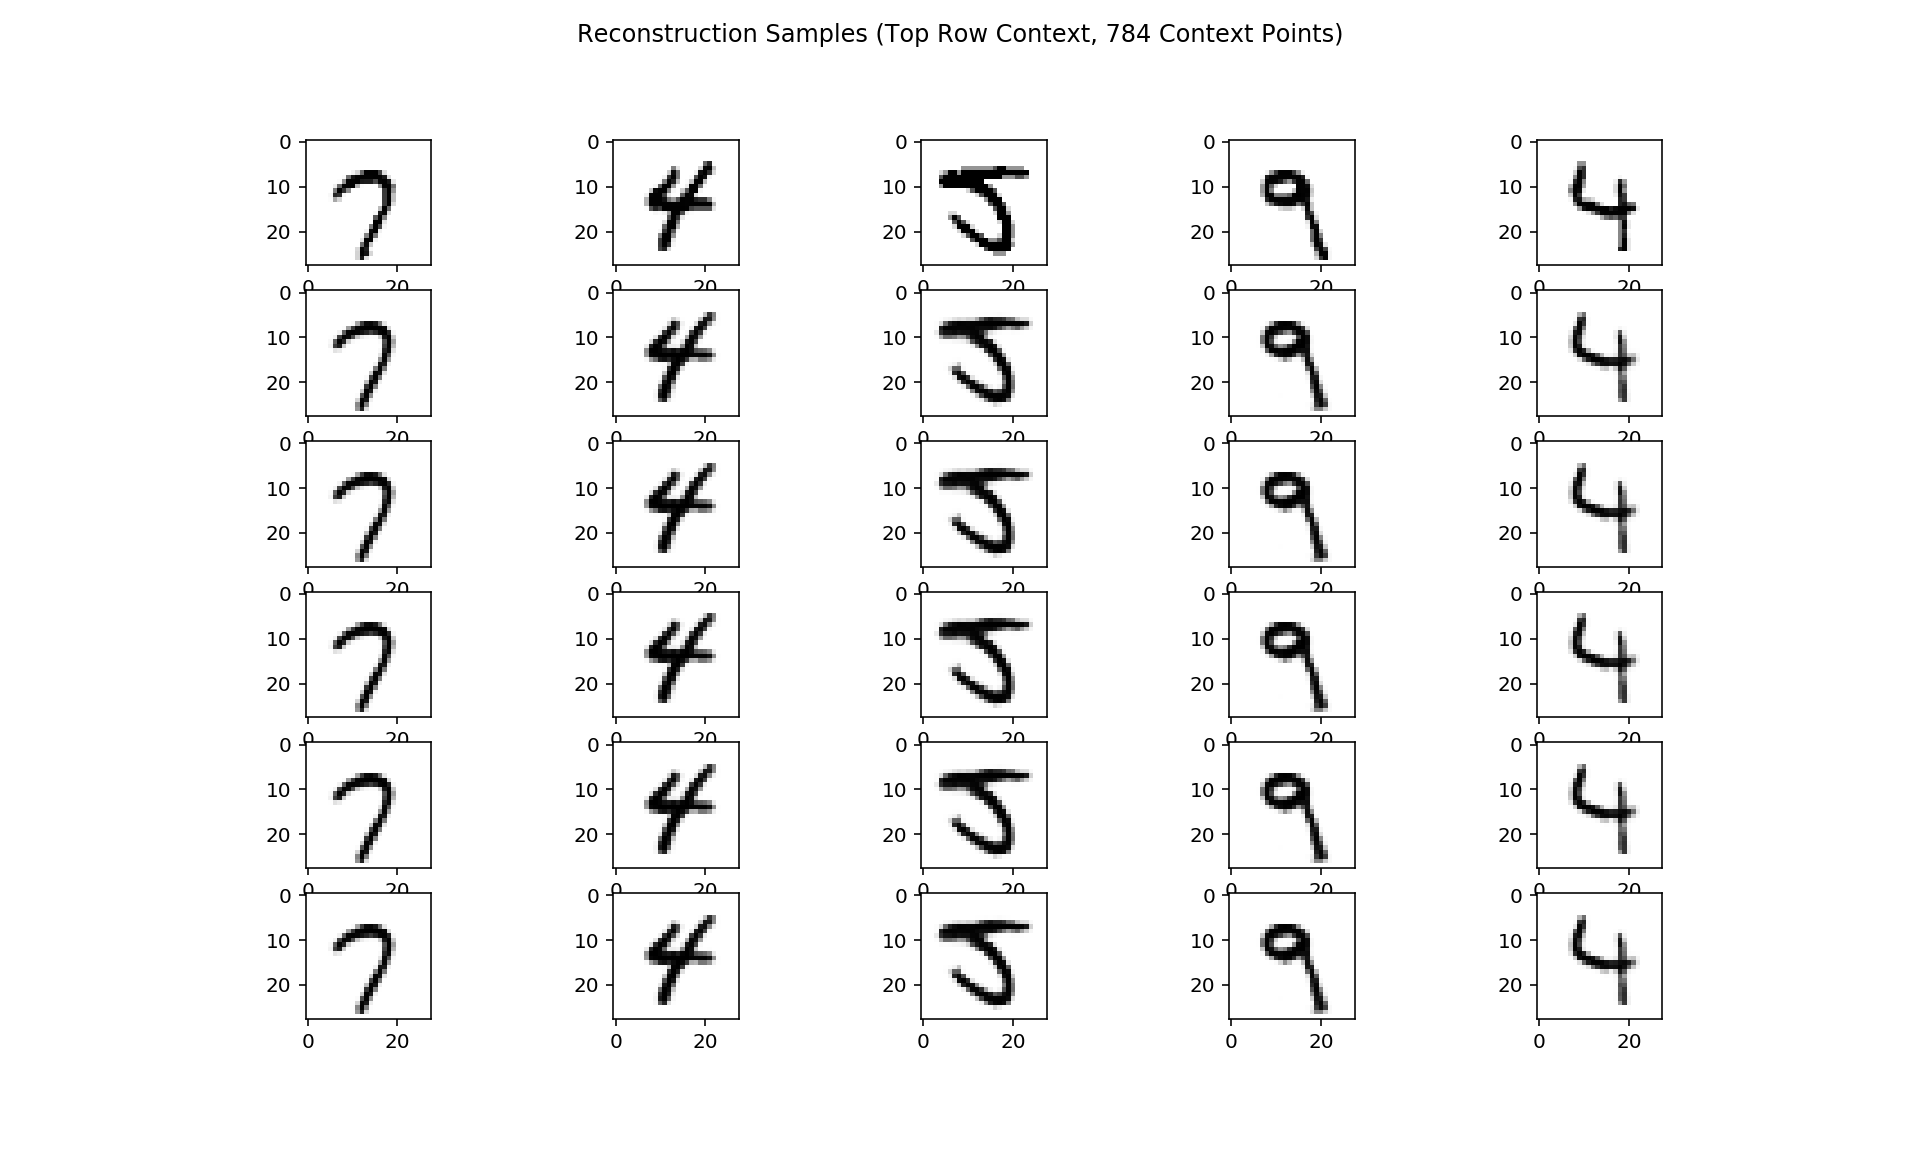

In [21]:
%matplotlib notebook
def create_image_context(image, number_of_context):
    original_height = image.shape[0]
    original_width = image.shape[1]
    
    flatten_image = image.reshape(-1, 1)

    flatten_image_height = flatten_image.shape[0]
    flatten_image_width = flatten_image.shape[1]
    
    context_indices = np.random.choice(flatten_image_height, number_of_context, replace=False)
    
    new_image = torch.zeros((flatten_image_height, flatten_image_width))

    new_image[context_indices, :] = flatten_image[context_indices, :]
    new_image = new_image.reshape(original_width, original_height)

    return new_image


counter = 0
context_points = [10, 100, 300, 784]

test_digits = None
for batch_idx, (data, target) in enumerate(test_loader):
    if batch_idx == 1:
        break
    
    test_digits = data[:5, 0]
    
for context in context_points:
    fig, ax = plt.subplots(6, 5)
    fig.suptitle('Reconstruction Samples (Top Row Context, %d Context Points)' % context)
                 
    digit_counter = 0
    for image in test_digits:
        context_image = create_image_context(image, context)
        ax[0, digit_counter].imshow(context_image, cmap='Greys')

        x_grid_expand = x_grid.reshape(1, -1, 2)
        context_image = context_image.reshape(1, -1, 1)

        y_star, _, _, _ = neural_process.sample(x_grid_expand, 5, x_context=x_grid_expand, y_context=context_image)
        y_star = nn.Sigmoid()(y_star)

        for i, sample in enumerate(y_star):
            ax[i + 1][digit_counter].imshow(sample.view(28, 28).data.numpy(), cmap='Greys')

        digit_counter += 1

        if digit_counter == 5:
            break
            

    plt.show()

    
    